In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy.stats import mode
from tqdm.notebook import tqdm
from p_tqdm import p_map

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
df_combined = pd.read_csv('../../search_results/LOPQ+Both+resnet18+256+20.csv', index_col=None)

In [5]:
excluded_classes = ['0235_D01_S001', '0200_D01_S001', '0049_D01_S001', '0842_D01_S001', '0337_D01_S001', '0263_D01_S001', '0735_D01_S001', '0541_D01_S001', '0311_D01_S001']
len(excluded_classes)

9

In [6]:
df_combined.sample(10)

,distance,uuid_actual,uuid_predicted,sample_actual,package_actual,descriptor_actual,package_predicted,algorithm,match
29165421,13.087810,PFP_Ph3_P0246_D01_S001_C2_az220_side1_0025,PFP_Ph3_P0880_D01_S001_C2_az360_side1_0008,Ph3_P0246_D01_S001_C2_az220,0246_D01_S001,25,0880_D01_S001,MI1,False
32560415,16.199186,PFP_Ph3_P0839_D01_S001_C4_az240_side1_0025,PFP_Ph3_P0839_D01_S001_C4_az360_side1_0014,Ph3_P0839_D01_S001_C4_az240,0839_D01_S001,25,0839_D01_S001,MI1,True
6812799,5.488522,PFP_Ph3_P0803_D01_S001_C2_az020_side1_0025,PFP_Ph3_P0401_D01_S001_C3_az360_side1_0003,Ph3_P0803_D01_S001_C2_az020,0803_D01_S001,25,0401_D01_S001,MSER,False
15924656,10.714216,PFP_Ph3_P0166_D01_S001_C2_az080_side1_0012,PFP_Ph1_P0037_D01_S004_C2_az360_side1_0006,Ph3_P0166_D01_S001_C2_az080,0166_D01_S001,12,0037_D01_S004,MSER,False
2202016,10.231207,PFP_Ph3_P0364_D01_S001_C4_az280_side1_0020,PFP_Ph1_P0629_D01_S001_C1_az360_side1_0006,Ph3_P0364_D01_S001_C4_az280,0364_D01_S001,20,0629_D01_S001,MSER,False
322799,10.498666,PFP_Ph2_P0503_D01_S001_C3_az220_side1_0001,PFP_Ph3_P0745_D01_S001_C2_az360_side1_0001,Ph2_P0503_D01_S001_C3_az220,0503_D01_S001,1,0745_D01_S001,MSER,False
32754206,13.442729,PFP_Ph1_P0807_D01_S001_C3_az060_side1_0001,PFP_Ph1_P0475_D01_S002_C1_az360_side1_0001,Ph1_P0807_D01_S001_C3_az060,0807_D01_S001,1,0475_D01_S002,MI1,False
10883104,0.297478,PFP_Ph2_P0021_D01_S001_C3_az020_side1_0005,PFP_Ph3_P0604_D01_S001_C1_az360_side1_0004,Ph2_P0021_D01_S001_C3_az020,0021_D01_S001,5,0604_D01_S001,MSER,False
9893925,0.671331,PFP_Ph2_P0764_D01_S001_C2_az020_side1_0006,PFP_Ph1_P0568_D01_S001_C1_az360_side1_0001,Ph2_P0764_D01_S001_C2_az020,0764_D01_S001,6,0568_D01_S001,MSER,False
32421023,10.878998,PFP_Ph3_P0765_D01_S001_C2_az220_side1_0008,PFP_Ph3_P0473_D01_S001_C3_az360_side1_0001,Ph3_P0765_D01_S001_C2_az220,0765_D01_S001,8,0473_D01_S001,MI1,False


In [7]:
df_combined = df_combined[~df_combined.package_actual.isin(excluded_classes)]
df_combined.package_actual.nunique()

989

In [8]:
df_agg = df_combined.sort_values(['distance'],ascending=True).groupby(['uuid_actual', 'algorithm'])

In [9]:
total_amount = df_combined.sample_actual.nunique()

In [10]:
algs = ['MSER', 'MI1', 'Both']
df_plot = pd.DataFrame(
    columns=pd.MultiIndex.from_product([algs, ['list_size', 'miss_prob']], names=['algorithm', 'neighbours'])
)

In [11]:
df_plot

Empty DataFrame
Columns: [(MSER, list_size), (MSER, miss_prob), (MI1, list_size), (MI1, miss_prob), (Both, list_size), (Both, miss_prob)]
Index: []

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

In [25]:
for top_n in [20]:
    df_head = df_agg.head(top_n)
    for alg in algs:
        if alg != 'Both':
            df_head_alg = df_head[df_head.algorithm == alg]
        else:
            df_head_alg = df_head
        
        df_plot.loc[top_n, (alg, 'miss_prob')] = df_head_alg[df_head_alg.package_actual == df_head_alg.package_predicted].sample_actual.nunique() / total_amount
        df_plot.loc[top_n, (alg, 'list_size')] = int(df_head_alg.groupby('sample_actual').package_predicted.nunique().mean())
        print(top_n, '\t', alg)

20 	 MSER
20 	 MI1
20 	 Both


In [31]:
1 - df_plot.loc[:, (slice(None), 'miss_prob')]

algorithm,MSER,MI1,Both
neighbours,miss_prob,miss_prob,miss_prob
1,0.0215311,0.0116272,0.00128751
3,0.0133109,0.00372388,0.000376349
5,0.0111716,0.00281272,0.000336734
7,0.0102407,0.0025156,0.000316926
9,0.00958701,0.00223829,0.000297118
11,0.00897296,0.00215906,0.00027731
13,0.00845796,0.00207983,0.00027731
15,0.00808161,0.00206002,0.00027731
17,0.00792315,0.00196098,0.00027731


<ipython-input-14-282583b09f1c>:5: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([p1, p2, p3], labels=['Both', 'MSER', 'MI1']) #


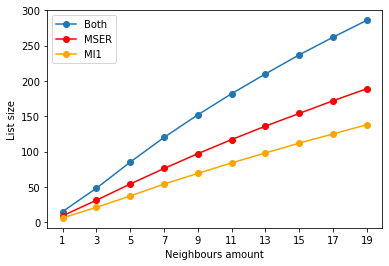

In [14]:
p1 = plt.plot(df_plot['Both']['list_size'], 'o-', label='Both')
p2 = plt.plot(df_plot['MSER']['list_size'], 'o-', color='red', label='MSER')
p3 = plt.plot(df_plot['MI1']['list_size'], 'o-', color='orange', label='MI1')

plt.legend([p1, p2, p3], labels=['Both', 'MSER', 'MI1']) # 

plt.xticks(df_plot.index.to_list(), df_plot.index.to_list())
plt.xlabel('Neighbours amount')
plt.ylabel('List size')
plt.savefig('list_size.png')

<ipython-input-15-38bad73c460d>:5: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([p1, p2, p3], labels=['Both', 'MSER', 'MI1']) #


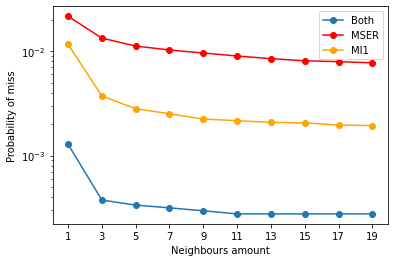

In [15]:
p1 = plt.plot(1 - df_plot['Both']['miss_prob'], 'o-', label='Both')
p2 = plt.plot(1 - df_plot['MSER']['miss_prob'], 'o-', color='red', label='MSER')
p3 = plt.plot(1 - df_plot['MI1']['miss_prob'], 'o-', color='orange', label='MI1')

plt.legend([p1, p2, p3], labels=['Both', 'MSER', 'MI1']) # 
plt.yscale('log')
plt.xticks(df_plot.index.to_list(), df_plot.index.to_list())
plt.xlabel('Neighbours amount')
plt.ylabel('Probability of miss')
plt.savefig('miss_prob.png')

In [27]:
(1 - df_plot['Both']['miss_prob']).min()

0.0002575022283847206

In [33]:
df_head_ex = df_agg.head(20)

In [ ]:
df_head_ex[df_head_ex.package_actual != df_head_ex.package_predicted]

In [34]:
df_pivvv = df_head_ex[['sample_actual', 'package_actual', 'uuid_actual', 'match']].pivot_table(index=['sample_actual', 'package_actual'], columns='match', values='uuid_actual', aggfunc='count', fill_value=0)

In [49]:
df_pivvv[df_pivvv[True] == 0].reset_index().package_actual.value_counts()

0887_D01_S001    4
0279_D01_S001    3
0471_D01_S001    3
0325_D01_S001    1
0498_D01_S001    1
0401_D01_S001    1
Name: package_actual, dtype: int64

In [30]:
(50000 - 300) / 50000

0.994

In [41]:
df_pivvv['ratio'] = df_pivvv[True] / df_pivvv[False]

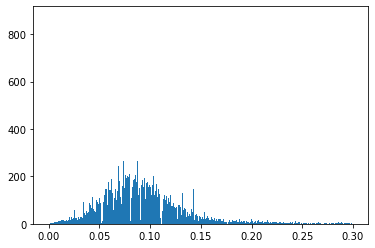

In [48]:
b = plt.hist(df_pivvv[df_pivvv.ratio < 0.3]['ratio'], bins=1000)